# TensorFlow Neural Machine Translation on Cloud TPUs

This tutorial demonstrates how to translate text using a LSTM Network from one language to another (from English to German in this case). We will work with a dataset that contains pairs of English-German phrases. Given a sequence of words in English, we train a model to predict the German equivalent in the sequence.

Note: Enable TPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware acclerator > TPU. If running locally make sure TensorFlow version >= 1.11.

This tutorial includes runnable code implemented using [tf.keras](https://www.tensorflow.org/programmers_guide/keras).

In [2]:
!ls
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

sample_data
--2019-08-11 12:27:55--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4541707 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   4.33M  15.2MB/s    in 0.3s    

2019-08-11 12:27:55 (15.2 MB/s) - ‘deu-eng.zip’ saved [4541707/4541707]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [3]:
!head deu.txt

Hi.	Hallo!
Hi.	Grüß Gott!
Run!	Lauf!
Wow!	Potzdonner!
Wow!	Donnerwetter!
Fire!	Feuer!
Help!	Hilfe!
Help!	Zu Hülf!
Stop!	Stopp!
Wait!	Warte!


### Importing TensorFlow and other libraries

Here, apart from `Tensorflow`, we will also be importing the helper functions from the `tf.keras` library to help with cleaning and preprocessing the dataset

In [0]:
import string
import numpy as np
from numpy import array
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, RepeatVector, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Extracting lines from dataset and into array

Here, we can examine how the dataset is structures. The English-German dataset comprises of an English and German phrase separted by a tab `\t`

In [5]:
deu_eng = open('./deu.txt', mode='rt', encoding='utf-8')
deu_eng = deu_eng.read()
deu_eng = deu_eng.strip().split('\n')
deu_eng = [i.split('\t') for i in deu_eng]
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000, :]
print (deu_eng[:5])

[['Hi.' 'Hallo!']
 ['Hi.' 'Grüß Gott!']
 ['Run!' 'Lauf!']
 ['Wow!' 'Potzdonner!']
 ['Wow!' 'Donnerwetter!']]


### Removing punctuation

We will be removing punctuation from the phrases and converting them to lowercase. We will not be creating embeddings for punctuations or uppercase characters as it adds to the complexity of the NMT model.

In [6]:
deu_eng[:, 0] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 1]]

for i in range(len(deu_eng)):
    deu_eng[i, 0] = deu_eng[i, 0].lower()
    deu_eng[i, 1] = deu_eng[i, 1].lower()

print (deu_eng[:5])

[['hi' 'hallo']
 ['hi' 'grüß gott']
 ['run' 'lauf']
 ['wow' 'potzdonner']
 ['wow' 'donnerwetter']]


### Tokenising the phrases

Tokenisation is the process of taking a sequence and chopping it up into smaller pieces called `tokens`. For example, suppose we have a sentence 

`"Bob returned home after the party"`

The tokenised sentence will return an array with the tokens:

`["Bob", "returned", "home", "after", "the", "party"]`

In this section, we will be breaking up the phrases into tokenised sequences that comprises of numbers for each unique word. For instance, the word "good" may have the value of 32 while the word "boy" may have the value of 46. Supposing the phrase is "good boy", the tokenised sequence is `[32, 46]`.

In [7]:
def tokenize(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer
    
eng_tokenizer = tokenize(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_sequence_length = 8
print ('English vocabulary size: {}'.format(eng_vocab_size))

deu_tokenizer = tokenize(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_sequence_length = 8
print ('German vocabulary size: {}'.format(deu_vocab_size))

English vocabulary size: 6352
German vocabulary size: 10678


### Convert lines into sequences as input for the NMT model

We will now be using our Tokeniser to create tokenised sequences of the original English and German phrases from our dataset.

In [0]:
def encode_sequences(tokenizer, sequence_length, lines):
    sequence = tokenizer.texts_to_sequences(lines)
    sequence = pad_sequences(sequence, sequence_length, padding="post") # 0s after the actual sequence
    return sequence

### Splitting the dataset into training and testing sets

We will dividing our English-German dataset into two parts - training and testing.
We will be using the 80-20 split so that our model generalises well on the dataset while still having enough instances to test the model with.

In [9]:
train, test = train_test_split(deu_eng, test_size=.2, random_state=12)

x_train = encode_sequences(deu_tokenizer, deu_sequence_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_sequence_length, train[:, 0])

x_test = encode_sequences(deu_tokenizer, deu_sequence_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_sequence_length, test[:, 0])

print (x_train.shape, y_train.shape)
print (x_test.shape, x_test.shape)

(40000, 8) (40000, 8)
(10000, 8) (10000, 8)


### Training on a TPU

In order to connect to a TPU, we can follow 4 easy steps:

1. Connect to a TPU instance
2. Initialise a parallelly-distributed training `strategy`
3. Build our NMT model under the `strategy`
4. Train the model on a TPU

For more details on training on TPUs for free, feel free to check out [this](https://medium.com/@mail.rishabh.anand/tpu-training-made-easy-with-colab-3b73b920878f) article that covers the process in great detail.
<br>
Here, we can see that we have around 11 instances that are free for us to use. You won't always find 11 but that shouldn't be much of a problem as long as we have access to a single one.

In [ ]:
import os
import pprint # for pretty printing our device stats

# Connecting to TPU instance
if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

    with tf.Session(tpu_address) as session:
        devices = session.list_devices()

    print('TPU devices:')
    pprint.pprint(devices)

### Initialising a training strategy

Here, we will be initialising a parallelly-distributed training strategy. All this does is makes our code executable on a TPU. It also makes our general purpose `tf.keras` model compatible for TPU training.

In [11]:
# Initialising a parallelly-distributed training strategy
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

W0811 12:28:12.760934 139874475276160 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [12]:
# Building our model under that strategy

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
units = 512
in_timesteps = deu_sequence_length
out_timesteps = eng_sequence_length

with strategy.scope():
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    rms = RMSprop(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=rms)

    model.summary()

W0811 12:28:21.273466 139874475276160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 12:28:21.343526 139874475276160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 12:28:21.661533 139874475276160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.pytho

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            5467136   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 6352)           3258576   
Total params: 12,924,112
Trainable params: 12,924,112
Non-trainable params: 0
_________________________________________________________________


### Training our model on the training dataset

In [13]:
history = model.fit(x_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), epochs=30, steps_per_epoch=500)

Epoch 1/30


W0811 12:28:36.859959 139874475276160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_distributed.py:411: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


500/500 [==============================] - 13s 26ms/step - loss: 2.8356
Epoch 2/30
500/500 [==============================] - 8s 15ms/step - loss: 2.1901
Epoch 3/30
500/500 [==============================] - 8s 15ms/step - loss: 1.8496
Epoch 4/30
500/500 [==============================] - 8s 16ms/step - loss: 1.6087
Epoch 5/30
500/500 [==============================] - 8s 15ms/step - loss: 1.4174
Epoch 6/30
500/500 [==============================] - 8s 16ms/step - loss: 1.2542
Epoch 7/30
500/500 [==============================] - 8s 15ms/step - loss: 1.1097
Epoch 8/30
500/500 [==============================] - 8s 16ms/step - loss: 0.9866
Epoch 9/30
500/500 [==============================] - 8s 16ms/step - loss: 0.8774
Epoch 10/30
500/500 [==============================] - 8s 16ms/step - loss: 0.7793
Epoch 11/30
500/500 [==============================] - 8s 16ms/step - loss: 0.6960
Epoch 12/30
500/500 [==============================] - 8s 16ms/step - loss: 0.6268
Epoch 13/30
500/500 [==

### Checking the loss values

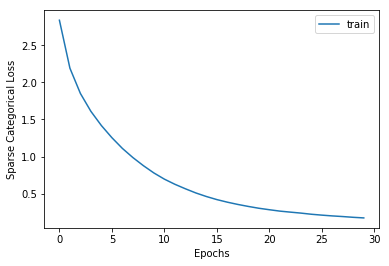

In [14]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Loss')
plt.legend(['train'])
plt.show()

### Running our model on testing dataset

Remember the the testing dataset from earlier? We will be using it to test how good our model is at translation.

In [15]:
# Getting the predictions from the testing dataset
preds = model.predict_classes(x_test.reshape(x_test.shape[0], x_test.shape[1]))
print (preds[:5])

[[  10  305    7   28  277    0    0    0]
 [   2   80    1    0    0    0    0    0]
 [  87   31   70   70    0    0    0    0]
 [   2   24    7   80    0    0    0    0]
 [  47   16 1456    0    0    0    0    0]]


In [0]:
# A function to convert a sequence back into words
def convert_words(n, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == n:
            return word
    return None

In [0]:
pred_texts = []
for i in preds:
    temp = []
    for j in range(len(i)):
        word = convert_words(i[j], eng_tokenizer)
        if j > 0:
            if (word == convert_words(i[j-1], eng_tokenizer)) or (word == None):
                temp.append('')
            else:
                temp.append(word)
        else:
            if (word == None):
                temp.append('')
            else:
                temp.append(word)
                
    pred_texts.append(' '.join(temp))    
    
pred_df = pd.DataFrame({'actual': test[:, 0], 'prediction': pred_texts})

In [18]:
pred_df

,actual,prediction
0,he wanted to be rich,he wanted to be rich
1,i love tom,i love tom
2,let us go home,lets go home
3,i love driving,i like to love
4,this is my dictionary,thats my dictionary
5,hi tom good morning,send tom a
6,why is she so popular,why is she so
7,ill show you my room,ill show you my room
8,did tom oversleep,did tom respond
9,keep up the good work,just a work
